# **Morphological operations**

<div style="color:#777777;margin-top: -15px;">
<b>Author</b>: Norman Juchler |
<b>Course</b>: ADLS ISP |
<b>Version</b>: v1.2 <br><br>
<!-- Date: 06.05.2025 -->
<!-- Comments: Entirely refactored -->
</div>

In this notebook, we demonstrate the effects of morphological operations on images.

Morphological operations are fundamental image processing techniques that analyze and modify images based on their shapes. Each operation requires two inputs: an image and a *structuring element*. The structuring element is typically a small binary matrix that defines the neighborhood used to process each pixel in the input image. It determines the shape and extent of the operation being applied. The illustration below shows several commonly used structuring elements.


![Common structuring elements](../data/doc/structuring-elements-2d.svg)  
**Figure 1**: Common structuring elements.

Similar to the kernels in a convolution, the structuring element is swept across the input image. However, the operations performed are different: instead of multiplying and summing pixel values, morphological operations are based on set theory and logical operations such as *intersection*, *union*, and *complement*.

For instance, the **erosion** operation (see below) computes the intersection of the image and the shifted structuring element: Only if all foreground pixels (value = 1) in the structuring element at a given position overlap with foreground pixels in the input image, the output pixel is set to 1 at that position. See Figure 2. 

Likewise, the **dilation** operation computes the union of the image and the shifted structuring element: If at least one foreground pixel in the structuring element overlaps with a foreground pixel in the input image, the output pixel is set to 1. See Figure 3.


![Binary erosion](../data/doc/binary-erosion.svg)  
**Figure 2**: Binary erosion of an input image (1) using a circular structuring element (2). Subfigures (3) and (4) show the result.

![Binary dilation](../data/doc/binary-dilation.svg)  
**Figure 3**: Binary dilation of an input image (1) using a circular structuring element (2). Subfigures (3) and (4) show the result.

Morphological operations are used for various image processing tasks, such as noise removal, object isolation, and feature enhancement. In this notebook, we will cover four basic operations: erosion, dilation, opening, and closing.  
Instead of providing formal definitions, we will explore their behavior through examples.

Credits: This notebook follows a tutorial from PyImageSearch, written by Adrian Rosebrock. [Link](https://pyimagesearch.com/2021/04/28/opencv-morphological-operations/)

---

## **Preparations**

The usual preparations... The package `isp` provides some helper functions to easily render images in this Jupyter notebook.

In [1]:
import sys
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Enable vectorized output (for nicer plots)
%config InlineBackend.figure_formats = ["svg"]

# Inline backend configuration
%matplotlib inline

# Functionality related to this course
sys.path.append("..")
import isp

# Jupyter / IPython configuration:
# Automatically reload modules when modified
%load_ext autoreload
%autoreload 2

---

## **Examplary image data**

In the following, we use a binary image containing some text and deliberately add noise to it.

A binary image contains only two possible values per pixel. Depending on the data type, these are typically 0 and 1 (dtype=bool), or 0 and 255 (dtype=np.uint8). Since OpenCV’s morphological operations expect images of type np.uint8, we will use this representation. In this format, pixels with the higher value are typically referred to as the **foreground**, while those with the lower value represent the **background**.

Note that the morphological operations can also be applied to grayscale and even color images, but for now let's assume binary images.

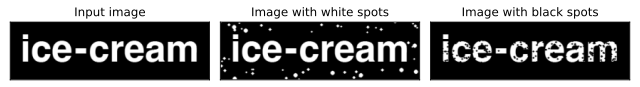

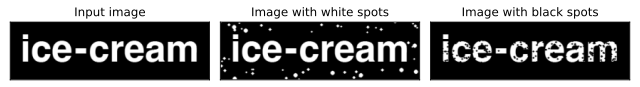

In [2]:
def sample_border(w, h, margin, inside=False):
    while True:
        x = np.random.randint(0, w)
        y = np.random.randint(0, h)
        is_valid = ((x < margin) or (x >= (w - margin)) 
                    or (y < margin) or (y >= h - margin))
        if inside:
            is_valid = not is_valid
        if is_valid:
            return x, y

# Read in the image and invert it
img = cv.imread("../data/images/word-ice-cream.png", cv.IMREAD_GRAYSCALE)
img = 255 - img

# Add dots of noise such that they do not overlap with the text.
h, w = img.shape
img_noisy_w = img.copy()  # Image with white spots
img_noisy_b = img.copy()  # Image with black spots
np.random.seed(1)
for i in range(50):
    x, y = sample_border(w, h, 20)
    r = np.random.randint(1, 4)
    cv.circle(img_noisy_w, (x, y), r, 255, -1, lineType=cv.LINE_AA)
for i in range(400):
    x, y = sample_border(w, h, 20, inside=True)
    cv.circle(img_noisy_b, (x, y), 1, 0, -1, lineType=cv.LINE_AA)

# Display the image
isp.show_image_chain([img, img_noisy_w, img_noisy_b], 
                     titles=["Input image", 
                             "Image with white spots", 
                             "Image with black spots"], 
                     suppress_info=True)



---

## **Erosion**

As the name suggests, erosion reduces or "erodes" the foreground regions in an image. It is useful for removing small blobs or noise, and for thinning visible structures.

Erosion works by defining a structuring element and sliding it across the input image from left to right and top to bottom. A foreground pixel in the output image is retained only if all corresponding pixels under the structuring element are greater than 0. Otherwise, the pixel is set to 0 (background). For grayscale images, the minimum value under the structuring element is used instead of applying a binary condition.

Note how the small white spots are removed by erosion, and how the text appears thinner after the operation.

In OpenCV, we can specify our own structuring element (SE), or use the default one (a 3×3 square). The SE defines the shape and size of the neighborhood that must completely fit within the foreground region for a pixel to remain in the output during erosion. A circular SE tends to produce rounded contours, while a square SE helps preserve corners and straight edges.


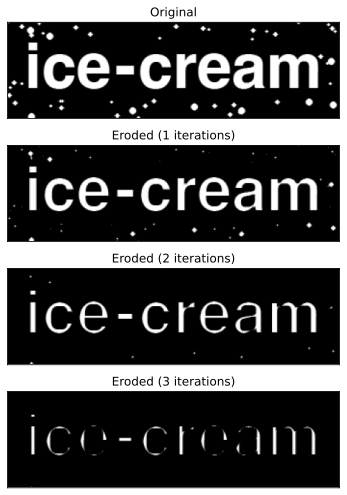

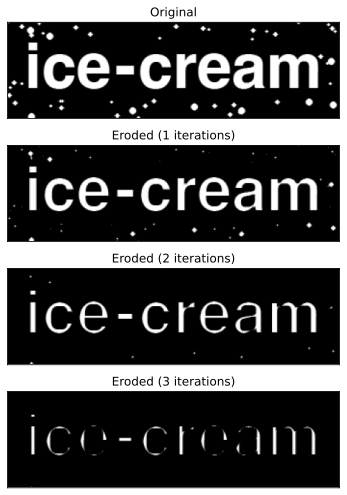

In [3]:
# We can specify our own structuring element (SE),
# or use the default one (a 3×3 square).
#se = np.ones((5, 5), np.uint8)
se = None

results = {}
results["Original"] = img_noisy_w
for i in range(1, 4):
    result = cv.erode(img_noisy_w, se, iterations=i)
    results[f"Eroded ({i} iterations)"] = result
    
isp.show_image_grid(results, suppress_info=True, ncols=1, figsize=(6, 7))

---

## **Dilation**

Dilation is the opposite to erosion. Instead of shrinking the foreground, dilation expands the boundaries of foreground objects in an image. It increases the size of foreground regions and is particularly useful for connecting broken components or filling small gaps.

Like erosion, dilation uses a structuring element (also called a kernel). A pixel in the output image is set to white (> 0) if at least one corresponding pixel under the structuring element is greater than zero. (For grayscale input images, the maximum value within the structuring element's neighborhood is taken.)


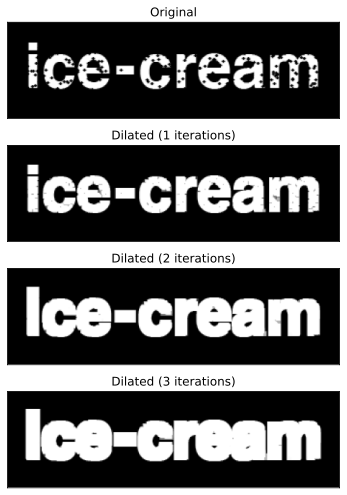

In [4]:
se = None  # Default structuring element, but you can specify your own
results = {}
results["Original"] = img_noisy_b
for i in range(1, 4):
    results[f"Dilated ({i} iterations)"] = cv.dilate(img_noisy_b, se, iterations=i)
    
isp.show_image_grid(results, suppress_info=True, ncols=1, figsize=(6, 7));
#isp.save_figure(path="morpho-dilation.png")

Note that erosion and dilation are dual operations under image complementation: applying erosion to the inverted image is equivalent to applying dilation to the original image, and vice versa (as long as the structuring element is symmetric). The following code illustrates this behavior:


In [5]:
se = np.ones((5, 5), np.uint8)
img_dilated = cv.dilate(img, se, iterations=1)
img_eroded = 255 - cv.erode(255-img, se, iterations=1)
img_diff = img_dilated - img_eroded
print("Test: The difference between dilated image and eroded complement of the image should be zero:")
print("      Measured difference = %d" % np.abs(img_diff).sum())

Test: The difference between dilated image and eroded complement of the image should be zero:
      Measured difference = 0


---

## **Opening**

An opening is an erosion followed by a dilation.

This operation is useful for removing small white blobs (noise) from an image while preserving the overall shape of larger objects. The erosion step eliminates small blobs and thins the structures, and the dilation step regrows the remaining regions to their original size.

In this example, we construct our own structuring element. OpenCV also provides a convenient function to create structuring elements: `cv.getStructuringElement(shape, ksize)`, where `type` can be one of `cv.MORPH_RECT`, `cv.MORPH_CROSS`, `cv.MORPH_ELLIPSE`; and `ksize` defines the size of the structuring element (kernel) in pixels. A structuring element is similar to a convolution kernel, but it is used in morphological operations, which follow different logical rules than standard convolutions.

Notice how the opening operation removes small white spots from the image. Larger kernels remove larger spots, but may also break thin parts of objects. Choosing the right kernel shape and size is crucial for the desired effect.

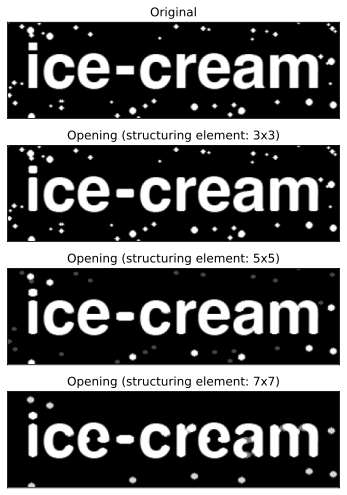

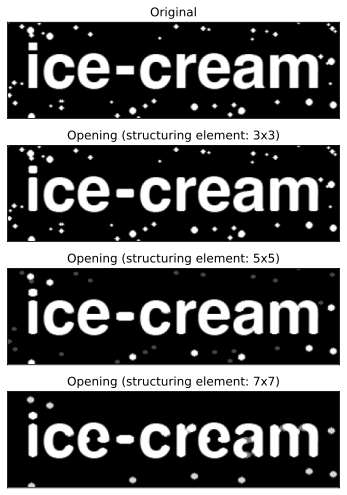

In [6]:
sizes = [(3, 3), (5, 5), (7, 7)]
results = {}
results["Original"] = img_noisy_w
for i, size in enumerate(sizes):
    # Construct a rectangular structuring elmenet from the 
    # current size and then apply an "opening" operation
    se = cv.getStructuringElement(cv.MORPH_ELLIPSE, size)
    ret = cv.morphologyEx(img_noisy_w, cv.MORPH_OPEN, se, iterations=1)
    results["Opening (structuring element: %dx%d)" % size] = ret
    
isp.show_image_grid(results, suppress_info=True, ncols=1, figsize=(6, 7))

---

## **Closing**

The closing operation is the opposite of opening: it consists of a dilation followed by an erosion.

As the name suggests, closing is used to *fill small holes* inside objects or to *connect nearby components*. The dilation step expands object boundaries, closing gaps or holes, and the erosion step then restores the original size while preserving the closure.

We can use the same code as for opening – only the type of morphological operation needs to be changed.

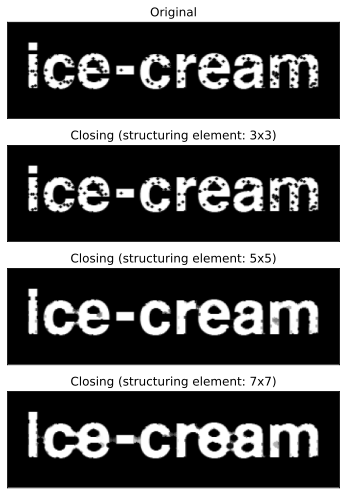

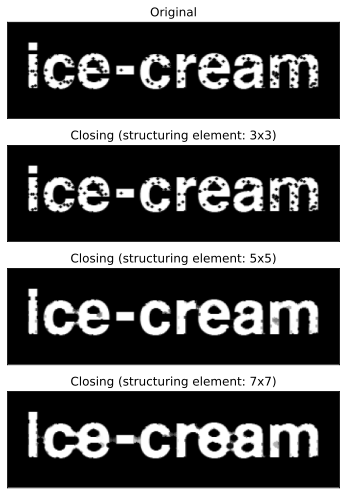

In [7]:
sizes = [(3, 3), (5, 5), (7, 7)]
results = {}
results["Original"] = img_noisy_b
for size in sizes:
    # Construct a rectangular structuring elmenet from the 
    # current size and then apply an "opening" operation
    se = cv.getStructuringElement(cv.MORPH_ELLIPSE, size)
    ret = cv.morphologyEx(img_noisy_b, cv.MORPH_CLOSE, se, iterations=1)
    results["Closing (structuring element: %dx%d)" % size] = ret
    
isp.show_image_grid(results, suppress_info=True, ncols=1, figsize=(6, 7))

---

## **Morphological gradient**

A morphological gradient is the difference between a dilation and an erosion of an image. It highlights the boundaries of objects and is useful for detecting edges or outlines in binary (or grayscale) images.

Again, we can use the same code structure from above.

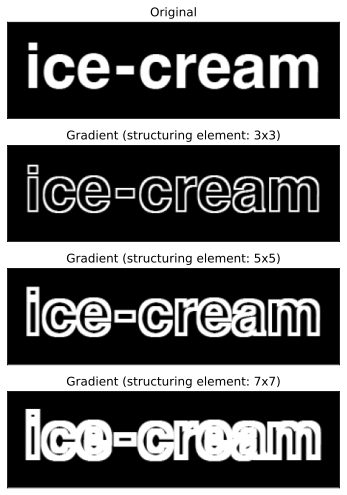

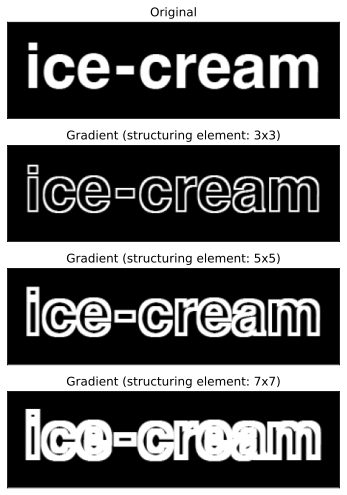

In [8]:
sizes = [(3, 3), (5, 5), (7, 7)]
results = {}
results["Original"] = img
for size in sizes:
    # Construct a rectangular structuring element from the 
    # current size and then apply an "opening" operation
    se = cv.getStructuringElement(cv.MORPH_RECT, size)
    ret = cv.morphologyEx(img, cv.MORPH_GRADIENT, se, iterations=1)
    results["Gradient (structuring element: %dx%d)" % size] = ret
    
isp.show_image_grid(results, suppress_info=True, ncols=1, figsize=(6, 7))

---

## **Morphological operations and grayscale images**

So far, we have applied morphological operations only to binary images. However, these operations are also defined for grayscale images (and even for color images, with some modifications).

Let's take a look at a brain MRI image to see how morphological operations behave in the grayscale domain. (Source: [Radiopaedia](https://radiopaedia.org/cases/normal-brain-mri-6))



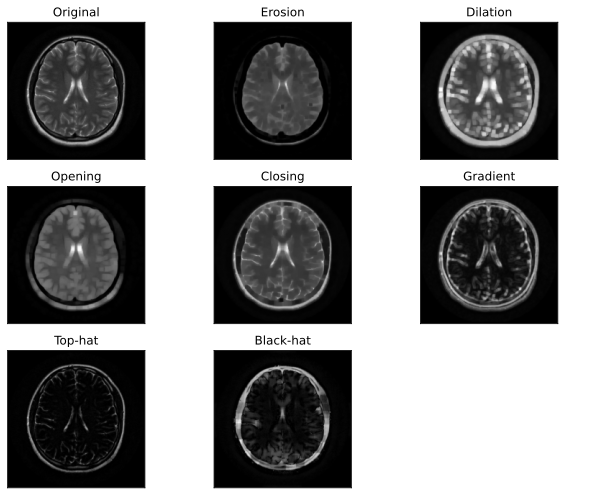

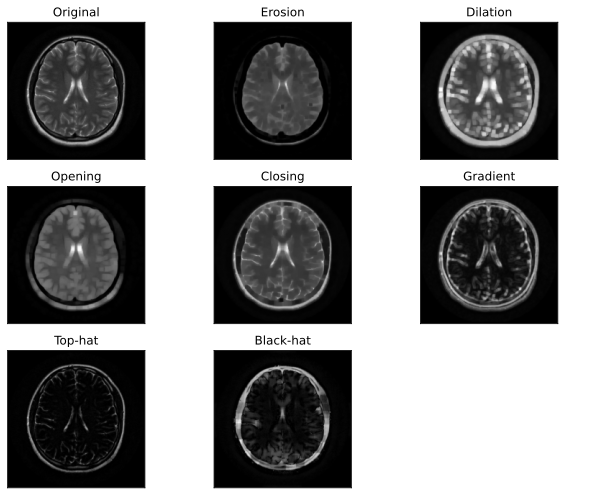

In [9]:
img_mri = cv.imread("../data/images/brain-mri/brain-mri-a-t2-dark.jpg", cv.IMREAD_GRAYSCALE)

size = (3, 3)
se = cv.getStructuringElement(cv.MORPH_RECT, size)
erode = cv.morphologyEx(img_mri, cv.MORPH_ERODE, se, iterations=5)
dilate = cv.morphologyEx(img_mri, cv.MORPH_DILATE, se, iterations=5)
opening = cv.morphologyEx(img_mri, cv.MORPH_OPEN, se, iterations=5)
closing = cv.morphologyEx(img_mri, cv.MORPH_CLOSE, se, iterations=5)
gradient = cv.morphologyEx(img_mri, cv.MORPH_GRADIENT, se, iterations=3)

size = (11, 11)
se = cv.getStructuringElement(cv.MORPH_RECT, size)
tophat = cv.morphologyEx(img_mri, cv.MORPH_TOPHAT, se, iterations=1)

size = (25, 25)
se = cv.getStructuringElement(cv.MORPH_RECT, size)
blackhat = cv.morphologyEx(img_mri, cv.MORPH_BLACKHAT, se, iterations=1)

results = {
    "Original": img_mri,
    "Erosion": erode,
    "Dilation": dilate,
    "Opening": opening,
    "Closing": closing,
    "Gradient": gradient,
    "Top-hat": tophat,
    "Black-hat": blackhat
}

isp.show_image_grid(results, suppress_info=True, ncols=3, figsize=(9, 7))

## **Top-hat (white-hat) and bottom-hat (black-hat)**

Both the top-hat (white-hat) and bottom-hat (black-hat) operators are generally more suitable for grayscale images than for binary ones.

A top-hat (also known as white-hat) operation is defined as the difference between the original grayscale (or single-channel) image and its opening.

The top-hat operation is used to reveal bright regions in an image with a dark background, assuming that these regions are smaller than the structuring element. In contrast, the black-hat operation highlights dark regions on a bright background. These operations are only effective when the structures of interest differ significantly in size from the structuring element.

A common application of the top-hat operation is the correction of uneven illumination and the enhancement of specific structures in the image.

In [10]:
h, w = img_mri.shape
x, y = np.meshgrid(np.arange(w), np.arange(h))
gradient = (x - w//2)**2 + (y - h//2)**2
gradient = gradient / gradient.max()
gradient = (gradient * 200).astype(np.uint8)
img_dist = (img_mri//2 + gradient//2)

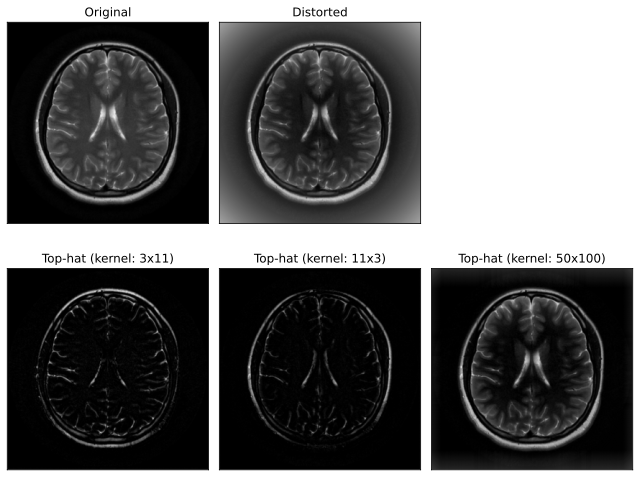

In [11]:
# Image with a continuous gradient from black to white
gradient = np.ones_like(img)
gradient = np.cumsum(gradient)

sizes = []
sizes.append((3,11))
sizes.append((11,3))
sizes.append((50,100))
results = {}
results["Original"] = img_mri
results["Distorted"] = img_dist
results["Dummy"] = None  # Placeholder (just for visualization)
for size in sizes:
    se = cv.getStructuringElement(cv.MORPH_RECT, size)
    ret = cv.morphologyEx(img_dist, cv.MORPH_TOPHAT, se, iterations=1)
    label = "Top-hat (kernel: %dx%d)" % size
    results[label] = ret

isp.show_image_grid(results, suppress_info=True, ncols=3, figsize=(9, 7));